# MSDS 430 Project 

## John Kelly, March 17, 2019
### City of Chicago Crime Data, 2014-2018

I originally proposed using geopandas package, but as of this week, I have had difficulty getting the installation done.  I am trying to use Windows 10 and Anaconda to perform the installation , and it has been troublesome. As of right now, I'm not sure I will do a mapping of the city of Chicago as I would have to find another Python package to complete it.  So that part of the project is not likely to be completed. I am going to have to go in a different direction for that part of the project and perhaps not use a map.  The thought would be to do a crime density contour plot.

The focus will shift to the time series analysis component of the project. I will look to see if there's another package that could be used for mapping the city of Chicago and overlay data on top of the map.  But the time series can involve building a model and forecasting time series.

In the previous milestone, I split the string using string methods. For this milestone and for the final project, I will use pandas' datetime type. Datetime will allow for more flexibility in dealing with analysis by month, year , or a certain time of the day.  One data frame will have standard indexing with a datetime as a column, or I can use the datetime type as an indexer.  I do both in this milestone assignment.

In [396]:
# John Kelly
# MSDS 430
# Final Projects
# March 13, 2019

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sea
import statsmodels as sm

#from pandas.io import data, wb
import scipy.stats as st
from statsmodels import tsa
from statsmodels.tsa import stattools as stt
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as smapi
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from datetime import datetime
from datetime import timedelta

In [127]:
# Import data from current directory - the last 5 years of data

crimes_14 = pd.read_csv('Crimes_-_2014.csv')
crimes_15 = pd.read_csv('Crimes_-_2015.csv')
crimes_16 = pd.read_csv('Crimes_-_2016.csv')
crimes_17 = pd.read_csv('Crimes_-_2017.csv')
crimes_18 = pd.read_csv('Crimes_-_2018.csv')
crime_frames = [crimes_14, crimes_15, crimes_16, crimes_17, crimes_18]

#concatenate all the data frames, this a union, these frames are on top of each other
crimes_df = pd.concat(crime_frames)

# change all columns to lower case for easier typing
crimes_df.columns = [s.lower() for s in crimes_df.columns]

#rename columns so that no spaces occur, so that dot notation
crimes_df =crimes_df.rename(columns={'location description': 'location_desc', 'case number': 'casenumber', 'community area': 'community'
                                   , 'primary type': 'primarytype', 'updated on': 'updated', 'x coordinate' : 'x',
                                     'y coordinate' : 'y', 'fbi code': 'fbi_code'})



In [128]:
# Count missing values
crimes_df.isnull().sum()
# MISSING VALUES

id                   0
casenumber           0
date                 0
block                0
iucr                 0
primarytype          0
description          0
location_desc     3359
arrest               0
domestic             0
beat                 0
district             1
ward                 8
community            2
fbi_code             0
x                13712
y                13712
year                 0
updated              0
latitude         13712
longitude        13712
location         13712
dtype: int64

In [129]:
# FIX MISSING VALUES (NaN)
crimes_df.location_desc = crimes_df.location_desc.fillna('UNKNOWN')
crimes_df.location = crimes_df.location.fillna('UNKOWN')

# fill other NaN values with zeros
crimes_df = crimes_df.fillna(0)
crimes_df.info()
#crimes_df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341171 entries, 0 to 265490
Data columns (total 22 columns):
id               1341171 non-null int64
casenumber       1341171 non-null object
date             1341171 non-null object
block            1341171 non-null object
iucr             1341171 non-null object
primarytype      1341171 non-null object
description      1341171 non-null object
location_desc    1341171 non-null object
arrest           1341171 non-null bool
domestic         1341171 non-null bool
beat             1341171 non-null int64
district         1341171 non-null float64
ward             1341171 non-null float64
community        1341171 non-null float64
fbi_code         1341171 non-null object
x                1341171 non-null float64
y                1341171 non-null float64
year             1341171 non-null int64
updated          1341171 non-null object
latitude         1341171 non-null float64
longitude        1341171 non-null float64
location         1341171 no

In [130]:
# create a datetime type, this will be necessary to do a time series analysis,
# and will provide the appropriate indexing;
# not sure how much of a headache it will be so, it may need further refinements

crimes_df['dt'] = pd.to_datetime(crimes_df['date'],format='%m/%d/%Y %I:%M:%S %p')

# create the date time format so that time series analysis can be done
d = pd.to_datetime(crimes_df['date'],format='%m/%d/%Y %I:%M:%S %p')

#get the date only
crimes_df['date1'] = d.dt.date

# get the time of day, this is in 24 hour format
crimes_df['timestamp'] = d.dt.time
crimes_df['month'] = d.dt.month

# Get the dimensions of the crimes data frame, rows x columns
dim_crimes = crimes_df.shape

In [276]:
# Get the number of observations and the number of columns of the data frame
data_len = len(crimes_df)
print("The length of the data is", data_len)
print("There are", dim_crimes[1], "data columns")
print("---------------------------------")

#crimes_df.info()
#crimes_df[['id', 'date1', 'primarytype', 'location_desc', 'month', 'year']].head(20)

The length of the data is 1341171
There are 26 data columns
---------------------------------


In [132]:
# check the type of the data
# crimes_df.dtypes

# set the index for the data as a timestamp
# this allows for easier time indexing, which is what I want

# the crimes_df has standard indexing, dt is the datetime column in the frame
# the crimes_ts has the datetime set as the indexing -- the dt is now the indexer for the frame
crimes_ts = crimes_df.set_index('dt')
crimes_ts.head(10)
print(type(crimes_ts.index))

# Sort the crimes
crimes_sorted = crimes_ts.sort_index()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


## Crimes, Yearly basis

In [135]:
# After the data has been in a time series format, the data can now be filtered, sliced, etc. according to year
# These data frames are a times series (index by datetime)
c_14 = crimes_sorted['2014']
c_15 = crimes_sorted['2015']
c_16 = crimes_sorted['2016']
c_17 = crimes_sorted['2017']
c_18 = crimes_sorted['2018']


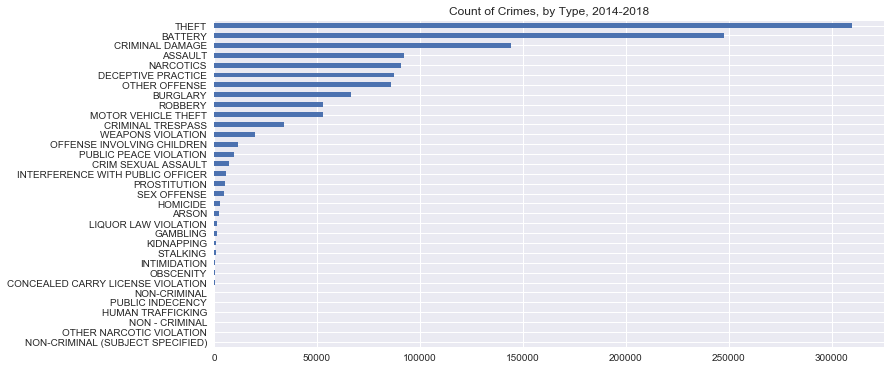

In [280]:
# Send the crime types to a Numpy Array
c_types = crimes_df['primarytype'].unique()
# Get the counts of each typ of crime and plot the result
crime_counts = crimes_df.primarytype.value_counts(ascending = True)
crime_counts.plot(kind = 'barh', title = "Count of Crimes, by Type, 2014-2018", figsize = (12,6))

## Monthly Crimes

In [227]:
# Create a data frame of the monthly crimes
monthly_14 = c_14.resample('M').size()
monthly_15 = c_15.resample('M').size()
monthly_16 = c_16.resample('M').size()
monthly_17 = c_17.resample('M').size()
monthly_18 = c_18.resample('M').size()
year = (monthly_14, monthly_15, monthly_16, monthly_17, monthly_18)
print("Monthly Crime Statistics, 2014 - 2018:")
print("Year\t Median\t Std. Deviation")
print("--------------------------------")
for i,y in enumerate(year, start = 2014):
    print("{0}\t {1}\t {2:.2f}".format(i, y.median(), y.std()))   

Monthly Crime Statistics, 2014 - 2018:
Year	 Median	 Std. Deviation
--------------------------------
2014	 23379.5	 2622.63
2015	 22355.0	 2237.27
2016	 22733.5	 1966.43
2017	 22355.5	 1680.70
2018	 22010.5	 2348.11


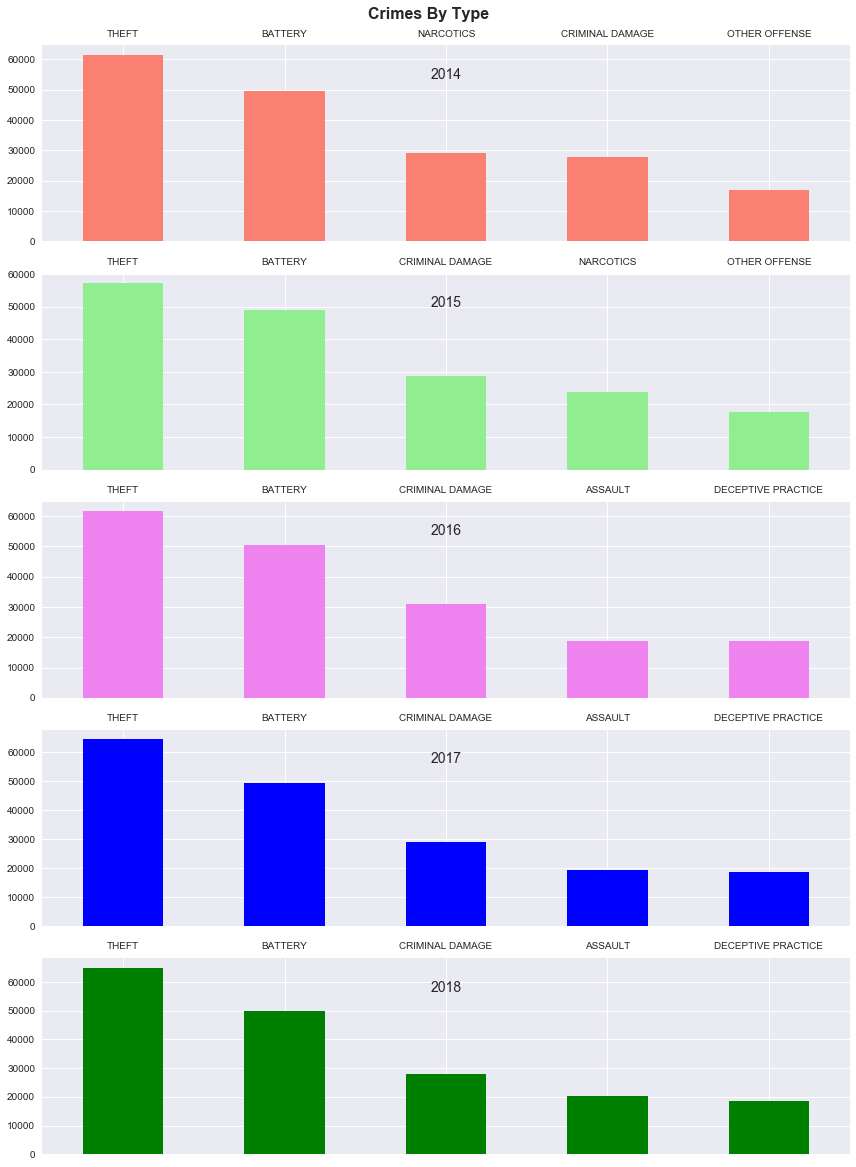

In [268]:
# The top 5 crimes for each year are determined.

types_14 = pd.value_counts(c_14['primarytype'].values, sort=True).head(5)
types_15 = pd.value_counts(c_15['primarytype'].values, sort=True).head(5)
types_16 = pd.value_counts(c_16['primarytype'].values, sort=True).head(5)
types_17 = pd.value_counts(c_17['primarytype'].values, sort=True).head(5)
types_18 = pd.value_counts(c_18['primarytype'].values, sort=True).head(5)

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows = 5, ncols = 1, sharex = False, figsize=(12,16))

types_14.plot(kind = 'bar', color = "salmon", ax = ax0)
ax0.xaxis.tick_top()
ax0.set_title("2014", y = 0.8, fontsize = 14)

types_15.plot(kind = 'bar', color = "lightgreen", ax=ax1)
ax1.xaxis.tick_top()
ax1.set_title("2015", y = 0.8, fontsize = 14)

types_16.plot(kind = 'bar', title = "2016", color = "violet", ax=ax2)
ax2.xaxis.tick_top()
ax2.set_title("2016", y = 0.8, fontsize = 14)

types_17.plot(kind = 'bar', title = "2017", color = "blue", ax=ax3)
ax3.xaxis.tick_top()
ax3.set_title("2017", y = 0.8, fontsize = 14)

types_18.plot(kind = 'bar', title = "2018", color = "green", ax=ax4)
ax4.xaxis.tick_top()
ax4.set_title("2018", y = 0.8, fontsize = 14)

fig.suptitle('Crimes By Type', fontsize = 16, fontweight = 'bold', y = 1.01 )
fig.tight_layout()

## Summer Months
The summer months have been notoriously dangerous months in the city of Chicago.

In [381]:
# Slice the summer months; slicing with loc since the index is a date time.
summer_14 = c_14.loc['May 2014':'Sep 2014']
summer_15 = c_15.loc['May 2015':'Sep 2015']
summer_16 = c_16.loc['May 2016':'Sep 2016']
summer_17 = c_17.loc['May 2017':'Sep 2017']
summer_18 = c_18.loc['May 2018':'Sep 2018']

# Group by month and for each type
s14 = summer_14['primarytype'].groupby(summer_14['month']).value_counts()
#print (s.groupby(level=0).nlargest(3).reset_index(level=0, drop=True))
s15 = summer_15['primarytype'].groupby(summer_15['month']).value_counts()
s16 = summer_16['primarytype'].groupby(summer_16['month']).value_counts()
s17 = summer_17['primarytype'].groupby(summer_17['month']).value_counts()
s18 = summer_18['primarytype'].groupby(summer_18['month']).value_counts()

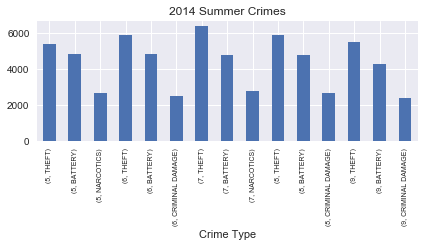

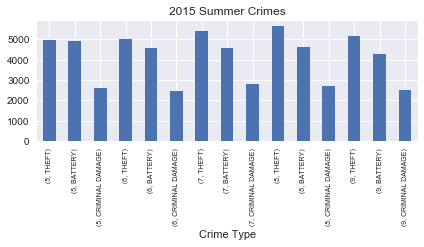

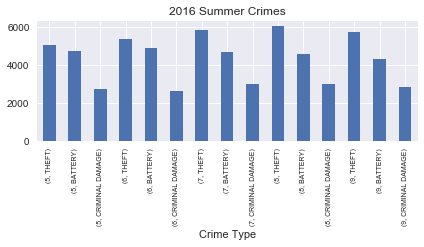

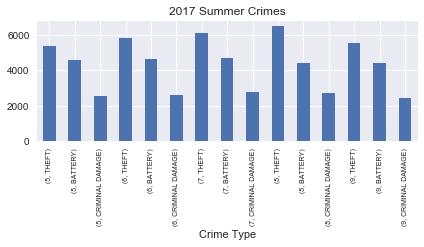

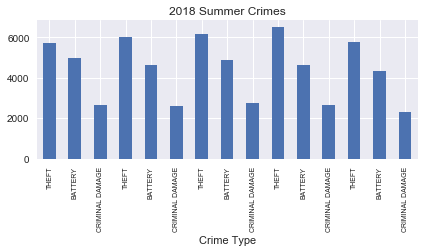

In [389]:
# From the Groupings, return the 3 largest counts for each month, and then plot
# The grouping here adds another index, so need to drop it since we use nlargest
# 2014
s_14 = s14.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)
s_14.plot.bar(title = "2014 Summer Crimes")
plt.tight_layout()
plt.xlabel("Crime Type")
plt.xticks(fontsize = '7')
plt.show()

#2015
s_15 = s15.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)
s_15.plot.bar(title = "2015 Summer Crimes")
plt.tight_layout()
plt.xlabel("Crime Type")
plt.xticks(fontsize = '7')
plt.show()

#2016
s_16 = s16.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)
s_16.plot.bar(title = "2016 Summer Crimes")
plt.tight_layout()
plt.xlabel("Crime Type")
plt.xticks(fontsize = '7')
plt.show()

#2017
s_17 = s17.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)
s_17.plot.bar(title = "2017 Summer Crimes")
plt.tight_layout()
plt.xlabel("Crime Type")
plt.xticks(fontsize = '7')
plt.show()

#2018
s_18 = s18.groupby(level=0).nlargest(3).reset_index(level=0, drop=True)
s_18.plot.bar(title = "2018 Summer Crimes")
plt.tight_layout()
plt.xlabel("Crime Type")
plt.xticks(fontsize = '7')
plt.show()

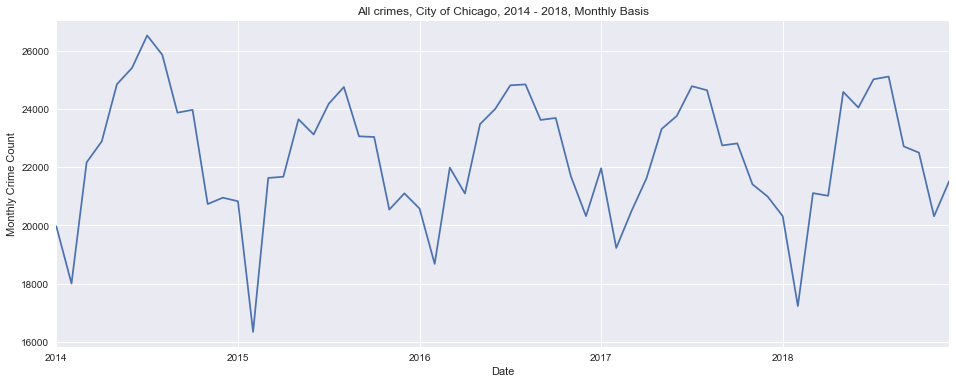

In [277]:
# Plot the number of crimes, without regard to crime type
monthly_crimes = crimes_sorted.resample('M').size()
monthly_crimes.plot(figsize = (16,6), title = "All crimes, City of Chicago, 2014 - 2018, Monthly Basis")
plt.ylabel("Monthly Crime Count")
plt.xlabel("Date")
#plt.legend('Monthly Crimes")
plt.show()

## Daily Crimes Analysis
Crimes can be analyzed on a monthly, weekly or daily basis. To provide the finest resolution, the crimes in city will be analyzed on a daily basis.

In [76]:
# Daily Crimes
# Resample for every day, the crimes are already sorted.
daily_crimes = crimes_sorted.resample('D').size()

Crimes in 2014 to 2018
----------------------
Monday had a total of 190221 crimes.
Tuesday had a total of 187947 crimes.
Wednesday had a total of 189770 crimes.
Thursday had a total of 189542 crimes.
Friday had a total of 201174 crimes.
Saturday had a total of 194964 crimes.
Sunday had a total of 187553 crimes.


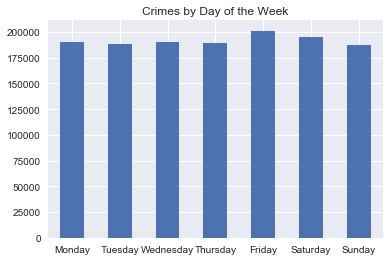

In [252]:
# Get the day counts, summing all crime types for each day
# for the aggreate from 2014 to 2018
day_counts = crimes_df['dt'].dt.weekday_name.value_counts()
day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
day_counts.reindex(day_name).plot(kind = 'bar', rot = 0, title = "Crimes by Day of the Week")
print("Crimes in 2014 to 2018")
print("----------------------")
for day in day_name:
    print("{0} had a total of {1} crimes.".format(day, day_counts[day]))

Theft, battery and criminal damage are the top 3 crimes on a daily basis in the city of Chicago over the last 5 years. A further investigation of these three crimes in conducted.

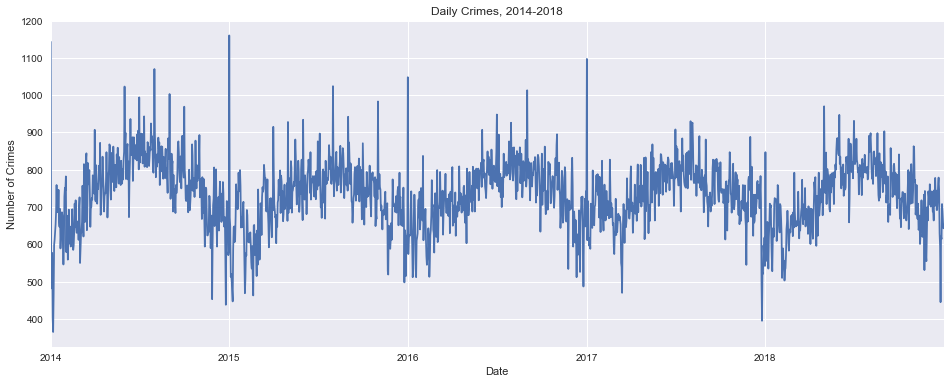

In [248]:
# Plot the daily crimes, all types
(daily_crimes.plot(figsize = (16,6), title = "Daily Crimes, 2014-2018"))
plt.ylabel("Number of Crimes")
plt.xlabel("Date")
plt.show()

C:\Users\JohnK\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=True).var()
  """


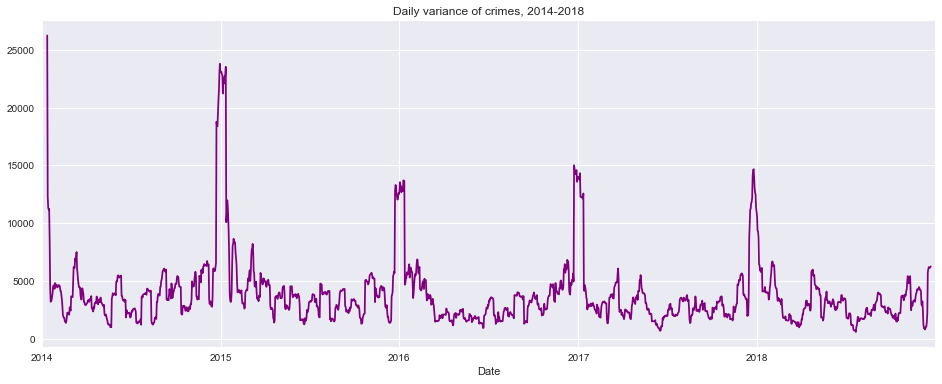

In [17]:
# Plot the variance of the orignial series
# Windowing changes the granularity of the computation
# Any way the windowing is change, at the end of the year and the start of the new year, the variance spikes

pd.rolling_var(daily_crimes, center = True, window = 20).plot(figsize = (16,6), color= 'Purple')
plt.xlabel("Date")
plt.title("Daily variance of crimes, 2014-2018")

## Augmented Dickey-Fuller Test
### Stationarity:
The data series needs to be checked for stationarity.  If the time series exhibits stationarity, then past values of the series can be used to determine present values of the series.  
Perform Dickey Fuller-Test from statsmodels.
The null hypothesis is that stationarity does not exist.

In [18]:
# Function to automate Dickey Fuller test
def station_test(series, maxlag = 5, autolag = None, regression = 'ct' ):
    """ Perform Dickey Fuller test
    series: the time series under consideration
    maxlag: the number of lags to test for
    auto lag: auto lags
    regression: constant and trend default"""

# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, 
# with the alternative that there is no unit root. 
# If the pvalue is above a critical size, then we cannot reject that there is a unit root    

    result = stt.adfuller(series, maxlag = maxlag, autolag = autolag, regression = regression)
    print("Augmented Dickey-Fuller Results")
    print("================================")
    print("adf stat:{0:>19.4f}".format(result[0]))
    print("p-value:{0:>20.4g}".format(result[1]))
    print("--------------------------")
    print("Critical Values at Lag {0}".format(maxlag))
    print("--------------------------")
    print("1%: {0:.5f}\n5%: {1:.5f}\n10%: {2:.5f}".format(result[4]["1%"], result[4]["5%"], result[4]["10%"]))
    print("The null hypothesis of unit root process is {0}".format(['rejected; stationarity exists', \
                                                            'not rejected;stationarity does not exist']\
                                                            [result[0]>result[4]["5%"]]))
    #return result

In [19]:
station_test(daily_crimes)

Augmented Dickey-Fuller Results
adf stat:            -7.7580
p-value:           2.591e-10
--------------------------
Critical Values at Lag 5
--------------------------
1%: -3.96375
5%: -3.41291
10%: -3.12847
The null hypothesis of unit root process is rejected; stationarity exists


Since the series exhibits stationarity, the Null Hypothesis of the Augmented Dickey Fuller test is rejected that the process has a unit root.  We can check the ACF and therefore the Ljung Box Statistic.

## Decomposition of daily crimes time series
Decomposition will remove any trend, seasonal, or cyclical component.  The goal is to extract the residual or random series component of the data and model that component of the series.

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Possible cyclical component for 365 days
daily_crimes_decomp = seasonal_decompose(daily_crimes, freq = 365)
daily_decomp_mult = seasonal_decompose(daily_crimes, model = 'multiplicative', freq = 365)

In [21]:
# Use the stats models package to de-trend the data :: seasonal :: trend :: random (residual) component
daily_trend = daily_crimes_decomp.trend
daily_seasonal = daily_crimes_decomp.seasonal
daily_resid = daily_crimes_decomp.resid
# *****************
# Compute trend, seasonal, residual if the for multiplicative effect
daily_trend_m = daily_decomp_mult.trend
daily_seasonal_m = daily_decomp_mult.seasonal
daily_resid_m = daily_decomp_mult.resid

## Plotting Additive Models

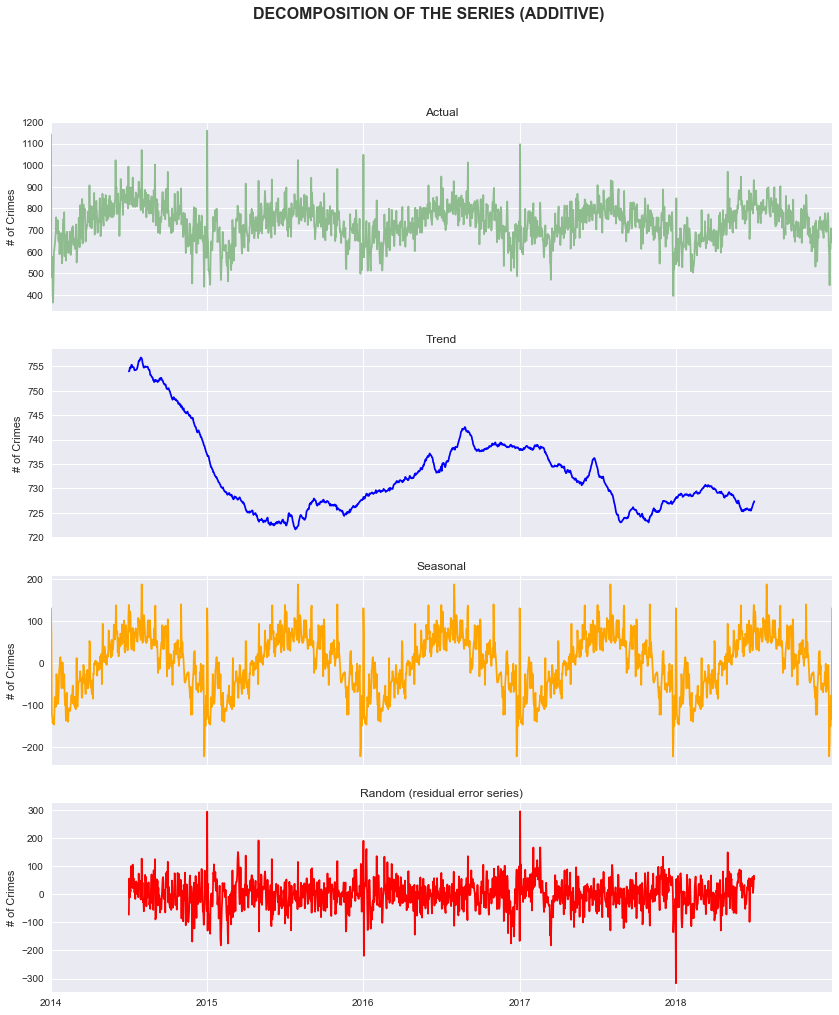

In [22]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows = 4, ncols = 1, sharex = True, figsize=(14,16))
daily_crimes.plot(color = 'darkseagreen', ax = ax0)
ax0.set(title = 'Actual', xlabel = 'Date', ylabel = '# of Crimes')

daily_trend.plot(color = "Blue", ax = ax1)
ax1.set(title = 'Trend', xlabel = '', ylabel = '# of Crimes')

daily_seasonal.plot(color = "Orange", ax = ax2)
ax2.set(title = 'Seasonal', xlabel = '', ylabel = '# of Crimes')

daily_resid.plot(color = "red", ax = ax3)
ax3.set(title = 'Random (residual error series)', xlabel = '', ylabel = '# of Crimes')
fig.suptitle('DECOMPOSITION OF THE SERIES (ADDITIVE)', fontsize = 16, fontweight = 'bold')

An additive model is more appropriate here.  The trend increases and decreases with time , and the variance of the observed series doesn't increase over time - it seems that the variance is constant.  A multiplicative model would be more appropriate if the trend component of the series was increasing with time.

### STATIONARITY TEST: Residual Series

A Dickey Fuller test is performed on the random or residual error series to determine if it is stationary. The goal of the analysis is to model this component of the observed crime series. A stationary model can be constructed on this component of the raw series.  364 data points have been removed from the original series to decompose the data.

In [23]:
# the NaN are dropped from the series since the ADF test does not accept NaN
daily_resid.dropna(inplace = True)
#print(len(daily_crimes))  #1826 days in the observed series
#print(len(daily_resid))   #1462 in the residual series
#print(daily_resid.head(1))  # series start July 2, 2014
#print(daily_resid.tail(1)) # series end July 2, 2018
station_test(daily_resid.dropna())

Augmented Dickey-Fuller Results
adf stat:           -11.7548
p-value:           9.772e-19
--------------------------
Critical Values at Lag 5
--------------------------
1%: -3.96500
5%: -3.41351
10%: -3.12883
The null hypothesis of unit root process is rejected; stationarity exists


## Auto Correlation

In [24]:
def acf_compute(xts,nlags = 10):
    """ xts: time series
        nlags: # to compute
        Plots the ACF correlogram, too"""
    
#     acf[0] -- acf values
#     acf[1] -- Lbox stats
#     acf[2] -- p-value for LBox stats
    
    acf = stt.acf(xts, nlags = nlags, qstat = True)
    acf_val = acf[0]
    # compute critical values for the correlogram
    crit_hi = 1.96 / np.sqrt(len(xts) - nlags)   # 5% level of significance, upper
    crit_lo = -1.96 / np.sqrt(len(xts) - nlags)  # 5% level of significance, lower
    
    # Plot the autocorrelogram

    # use tsa tools to plot the ACF
    fig , ax = plt.subplots(figsize = (14,7))
    plot_acf(xts, ax=plt.gca(), alpha = 0.05, lags = nlags, use_vlines = True)

    lag_var = 5
    print("Ljung-Box Statistics")
    print("--------------------") 
    serial_corr = False
    while lag_var <= nlags:
        print("Q({0})= {1:>8.2f}, p-val= {2:<10.3E}".format(lag_var, acf[1][(lag_var-1)], acf[2][(lag_var-1)]))
        if acf[2][(lag_var-1)] < 0.05:
            serial_corr = True
            serial_ind = lag_var-1
        lag_var += 5
    if serial_corr == True:
        print("Ho rejected: serial correlation exists")
    else:
        print("No serial correlation exists in the series.\nDo not reject Ho.")
    
    # Examin the auto correlation estimates verus critical values
    print("\nCritical Values")
    print("----------------")
    print("Upper:{0:.4f}, Lower:{1:.4f}".format(crit_hi, crit_lo))
    print("\nLag   ACF")
    print("---------")
    for i, auto_val in  enumerate (acf[0], 0):
        if auto_val > crit_hi:
            print("{0}   {1:.5f}".format(i, auto_val))
        else:
            break

## Partial AutoCorrelation Function

In [25]:
def pacf_compute(xts,nlags = 10):
    """ xts: time series
        nlags: # to compute to compute for PACF estimates
        Plots the PACF correlogram, too"""
    
#   pacf[0] -- pacf estimate statistics
    
    pacf = stt.pacf(xts, nlags = nlags)
    pacf_val = pacf
    # compute critical values for the correlogram
    crit_hi = 1.96 / np.sqrt(len(xts) - nlags)   # 5% level of significance, upper
    crit_lo = -1.96 / np.sqrt(len(xts) - nlags)  # 5% level of significance, lower
    
    # Plot the autocorrelogram
    fig , ax = plt.subplots(figsize = (14,7))
    plot_pacf(xts, ax=plt.gca(), alpha = 0.05, lags = nlags, use_vlines = True)
    
    print("\nCritical Values")
    print("----------------")
    print("Upper: {0:.4f}, Lower: {1:.4f}".format(crit_hi, crit_lo))
    print("\nLag   PACF")
    print("---------")
    for i, pauto_val in enumerate (pacf_val, 0):
        if pauto_val > crit_hi:
            print("{0}   {1:.5f}".format(i, pauto_val))
        else:
            break

### ACF and PACF for the residual series
ACF and PACFs are computed for the residual series to determine the order for either and Auto-Regressive model (PACF) or Moving Average (MA) model. Examining the correlogram will help determine the order.

Ljung-Box Statistics
--------------------
Q(5)=   151.29, p-val= 7.077E-31 
Q(10)=   219.64, p-val= 1.272E-41 
Q(15)=   241.77, p-val= 6.126E-43 
Q(20)=   245.59, p-val= 8.820E-41 
Ho rejected: serial correlation exists

Critical Values
----------------
Upper:0.0516, Lower:-0.0516

Lag   ACF
---------
0   1.00000
1   0.21495
2   0.17383
3   0.10643
4   0.11060
5   0.05678
6   0.12600
7   0.16321
8   0.06018


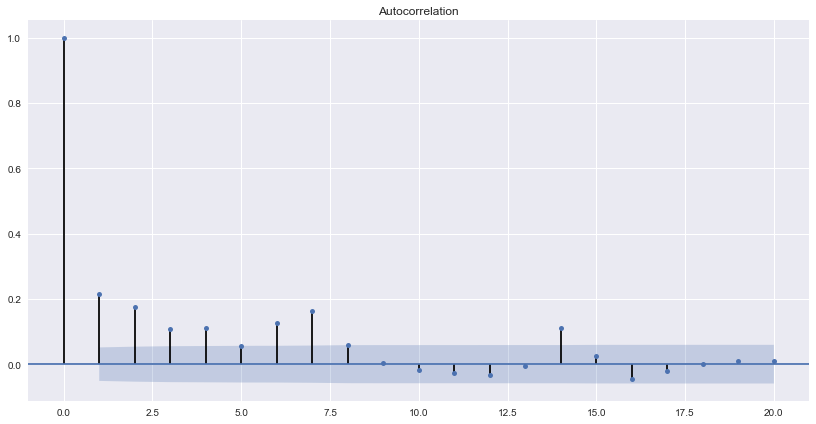

In [26]:
acf_compute(daily_resid, nlags = 20)

According to the plot and output, the first 8 lags are significant.  The level of siginificance is 5%, so 5% of non-significant lags can be plotted as significant.  The lag at 14 could be one such non-significant 'significant' lag.


Critical Values
----------------
Upper: 0.0516, Lower: -0.0516

Lag   PACF
---------
0   1.00000
1   0.21510
2   0.13400


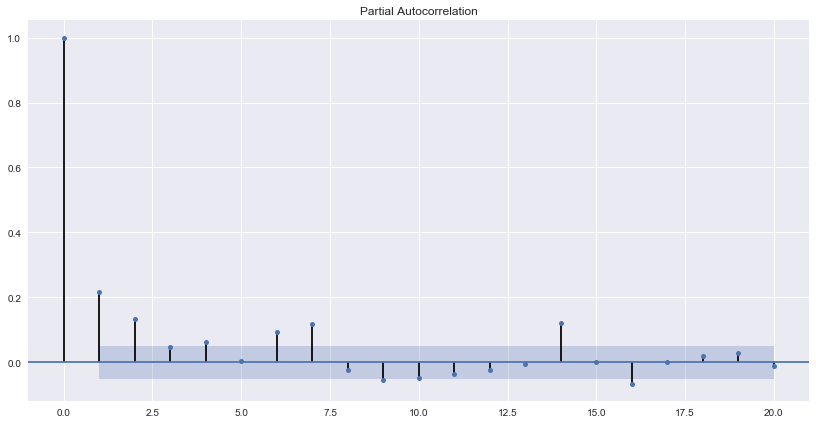

In [27]:
pacf_compute(daily_resid, nlags = 20)

For the PACF correlogram, the first two lags are significant, and the functions resulting output confirms this.

## Testing on Normality
### Jarque-Bera Test: Residual Series
Jarque Bera tests for normality of the the series. The null hypothesis is that the series comes from a normal distribution.  The alternaitve hypothesis is that it doesn't come from a normal distribution.

In [28]:
def normal_test(series):
    """
    Computes JB statistics on a residaul series
    The JB statistic is calculated for a residual series
    Returns:test statistic, p-value, skew, kurtosis
    """
    jb_test = jarque_bera(series)
    print("Jarque-Bera test statistic: {0:>3.3f}".format(jb_test[0]))
    print("Jarque-Bera p-value: {0:>16.3E}".format(jb_test[1]))
    print("Estimated skew: {:>17.3f}".format(jb_test[2]))
    print("Estimated kurtosis: {:>13.3f}".format(jb_test[3]))
    print("-------------------")
    if jb_test[1] < 0.05:
        print("The null hypothesis is rejected and the data does not come\nfrom a normal distribution")
    else:
        print("Do not reject the null hypothesis. Data is normally dsitibuted")
    
    hist, ax = plt.subplots(figsize=(12,6))
    
    ax = sea.distplot(series, kde = False)
    ax.set_title("Histogram for Residual Series")
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Residuals")
    plt.show()
  
    fig = smapi.qqplot(series, fit = True, line = 'r')
    plt.show()
    
    box, ax = plt.subplots(figsize = (10,3))
    ax = sea.boxplot(series, orient =  "h")
    ax.set_title("Boxplot")
    ax.set_xlabel("residuals" )

Jarque-Bera test statistic: 436.260
Jarque-Bera p-value:        1.850E-95
Estimated skew:            -0.077
Estimated kurtosis:         5.672
-------------------
The null hypothesis is rejected and the data does not come
from a normal distribution


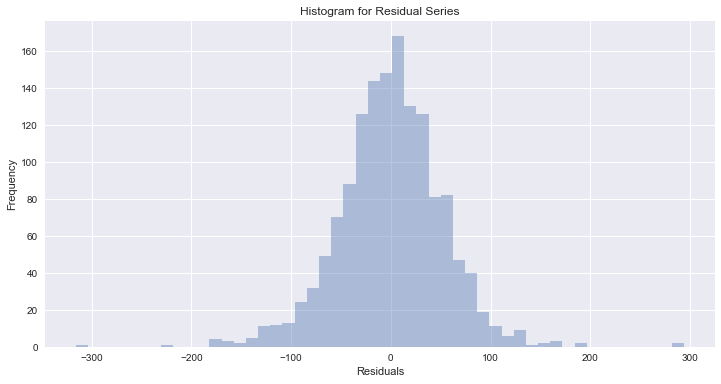

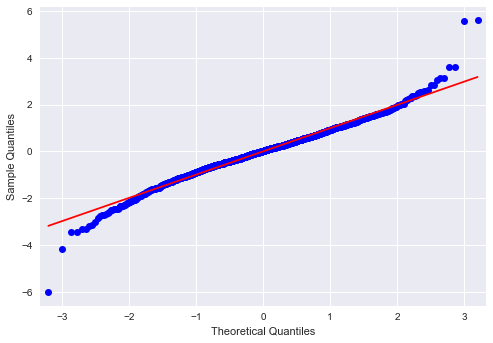

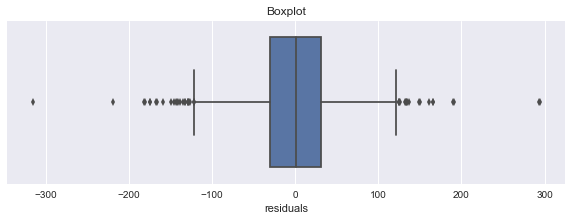

In [29]:
normal_test(daily_resid)
#print('statsmodels: {}'.format(statsmodels.__version__))

The Jarque-Bera statistic/p-value shows that residual component of the series is not normal. The QQ-Plot along with the histogram show that the tails may be larger than that of a normal distribution.  A box plot is also created to show that the resiudals that fall outside the IQR of the box plot, a further confirmation of the non-normality of the series.

## Time Series Modeling
An Autorgressive (AR(p)), a moving average (MA(q)) model, and a AutoRegressive Integrated Moving Aveage (ARIMA(p,q)) models will be created. The AR(p) model will be introduced, then the MA(q), and finally the ARIMA(p,q). Finally, Python's automatic ARMIA modeling will be used oto determine the order of the regressive and average terms.  The models will be fitted against the training data and the Akaike Informaiton Criterion will be used to compare models.  Diagnostics of the residuals will also be performed.  The residuals of the fitted models' ACF correlogram should have white noise like behavior, that is, the ACF of the residuals should quickly decay below the critical value for the series.

The data needs to be split into a traning set and test data set.
The years from July 2, 2014 to July 2017 (4 years, or 80% of the data) will consist of the training set, while the last year, 2018 will compose the test data set.

In [30]:
# Split the data into training data and test data  
#len(daily_resid)  # 1462 data points, 80 % of the data would be 1169 days, or observations

test_date_start = daily_resid.index[0]+ timedelta(days = 1169)
train = daily_resid[ :test_date_start - 1] # start to the 1168 (1169 observations)
test = daily_resid[test_date_start: ]
len(test)  # 1169
len(train) # 293

1169

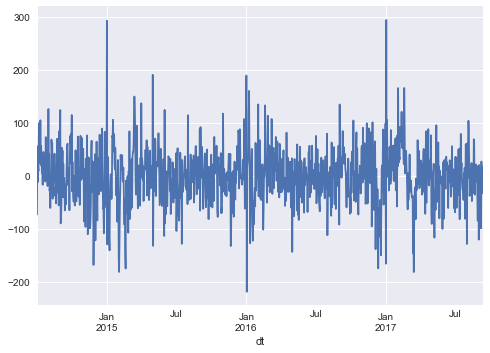

In [31]:
train.plot(kind = 'line')
plt.show()

In [32]:
#` Check the stationarity of the train data set.
station_test(train)

Augmented Dickey-Fuller Results
adf stat:           -10.5678
p-value:           1.555e-16
--------------------------
Critical Values at Lag 5
--------------------------
1%: -3.96658
5%: -3.41427
10%: -3.12928
The null hypothesis of unit root process is rejected; stationarity exists


### AR(p) model
The order, or number of lag terms of the AR model, is determined from the correlogram.  From the PACF plot above, there are 2 statistically significant lags from the correlogram. Therefore, an AR(2) model will be created.

In [33]:
ar = ARIMA(train, order = (2,0,0))
result_ar = ar.fit(disp=0)
result_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1169
Model:                     ARMA(2, 0)   Log Likelihood               -6260.285
Method:                       css-mle   S.D. of innovations             51.227
Date:                Fri, 15 Mar 2019   AIC                          12528.570
Time:                        21:36:41   BIC                          12548.826
Sample:                    07-02-2014   HQIC                         12536.210
                         - 09-12-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7037      2.165     -0.325      0.745      -4.947       3.540
ar.L1.y        0.1616      0.029      5.582      0.000       0.105       0.218
ar.L2.y        0.1468      0.029      5.071      0.000       0.090       0.204
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1169           +0.0000j            2.1169            0.0000
AR.2           -3.2173           +0.0000j            3.2173            0.5000
-----------------------------------------------------------------------------
"""

Both autoregresive coeffcients are statistically significant while the AIC of the model is 12528.57

Ljung-Box Statistics
--------------------
Q(5)=     6.10, p-val= 2.969E-01 
Q(10)=    35.53, p-val= 1.015E-04 
Q(15)=    58.41, p-val= 4.721E-07 
Q(20)=    63.53, p-val= 1.996E-06 
Ho rejected: serial correlation exists

Critical Values
----------------
Upper:0.0578, Lower:-0.0578

Lag   ACF
---------
0   1.00000


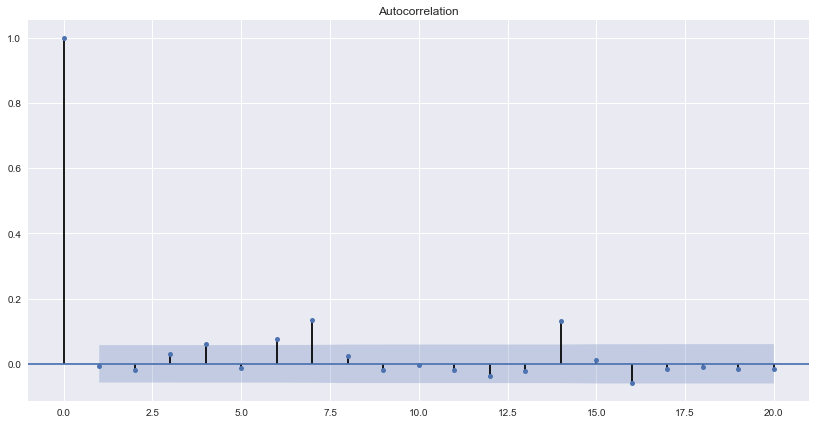

In [34]:
#Check the residuals
acf_compute(result_ar.resid, nlags = 20)

The AR(2) model's residual are shown above. While the autocorrelation estimates decay quickly, there seems to be a pattern for every 7th day that is significant.  At a level of 5% signiificane for 20 lags, 1 of the 20 lags could be shown as significant when it is not.  But there are 2 significant lags shown in the first 20 in the plot. 
Since the residuals do no exhibit are random pattern, this AR(2) model may not be adequate to model the data.
This is noted and the MA model will be fitted from ACF correlogram.

Jarque-Bera test statistic: 478.359
Jarque-Bera p-value:       1.336E-104
Estimated skew:             0.174
Estimated kurtosis:         6.115
-------------------
The null hypothesis is rejected and the data does not come
from a normal distribution


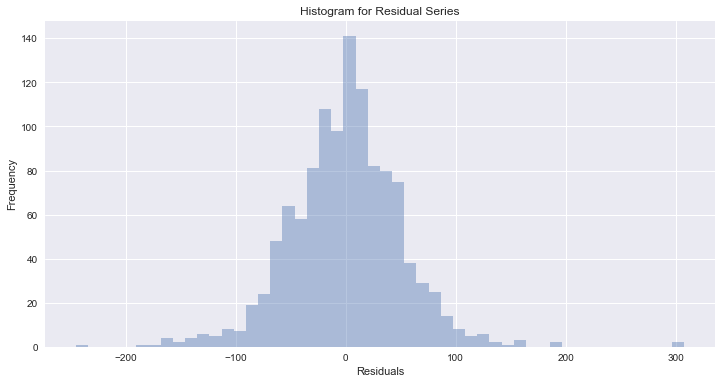

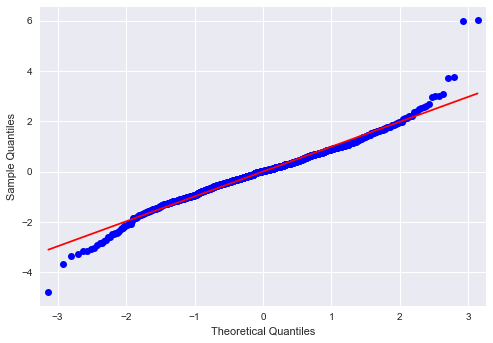

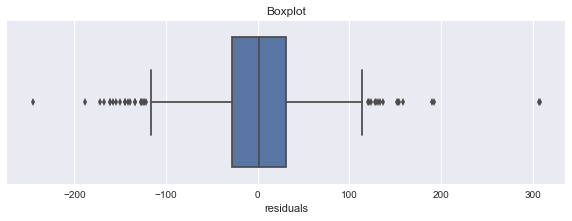

In [35]:
# Check the residual for normality as a customary check
normal_test(result_ar.resid)

### MA(8) model
The ACF is used to determine the order of the moving average model. Since 8 lags are significant in the ACF correlogram, a MA(8) model will be tried.

In [36]:
ma = ARIMA(train, order = (0,0,8))
result_ma = ma.fit()
result_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1169
Model:                     ARMA(0, 8)   Log Likelihood               -6243.699
Method:                       css-mle   S.D. of innovations             50.502
Date:                Fri, 15 Mar 2019   AIC                          12507.399
Time:                        21:37:06   BIC                          12558.038
Sample:                    07-02-2014   HQIC                         12526.499
                         - 09-12-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6976      2.591     -0.269      0.788      -5.776       4.380
ma.L1.y        0.1392      0.029      4.767      0.000       0.082       0.196
ma.L2.y        0.1430      0.029      4.893      0.000       0.086       0.200
ma.L3.y        0.0658      0.029      2.247      0.025       0.008       0.123
ma.L4.y        0.0965      0.030      3.248      0.001       0.038       0.155
ma.L5.y        0.0290      0.030      0.979      0.328      -0.029       0.087
ma.L6.y        0.1050      0.030      3.444      0.001       0.045       0.165
ma.L7.y        0.1334      0.027      4.927      0.000       0.080       0.186
ma.L8.y        0.0448      0.030      1.487      0.137      -0.014       0.104
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0765           -0.6407j            1.2528           -0.0854
MA.2            1.0765           +0.6407j            1.2528            0.0854
MA.3            0.2620           -1.2713j            1.2980           -0.2177
MA.4            0.2620           +1.2713j            1.2980            0.2177
MA.5           -0.9121           -1.1304j            1.4525           -0.3581
MA.6           -0.9121           +1.1304j            1.4525            0.3581
MA.7           -1.9149           -0.5777j            2.0001           -0.4534
MA.8           -1.9149           +0.5777j            2.0001            0.4534
-----------------------------------------------------------------------------
"""

All moving average estimates are significant, with the expection of the 5th and 8th estimate.

In [37]:
result_ma.conf_int()

,0,1
const,-5.775594,4.380295
ma.L1.y,0.081973,0.196445
ma.L2.y,0.085698,0.200228
ma.L3.y,0.008407,0.123249
ma.L4.y,0.038265,0.154696
ma.L5.y,-0.029003,0.086911
ma.L6.y,0.045245,0.164761
ma.L7.y,0.080330,0.186465
ma.L8.y,-0.014263,0.103883


Ljung-Box Statistics
--------------------
Q(5)=     0.05, p-val= 1.000E+00 
Q(10)=     0.57, p-val= 1.000E+00 
Q(15)=    18.27, p-val= 2.487E-01 
Q(20)=    22.21, p-val= 3.295E-01 
No serial correlation exists in the series.
Do not reject Ho.

Critical Values
----------------
Upper:0.0578, Lower:-0.0578

Lag   ACF
---------
0   1.00000


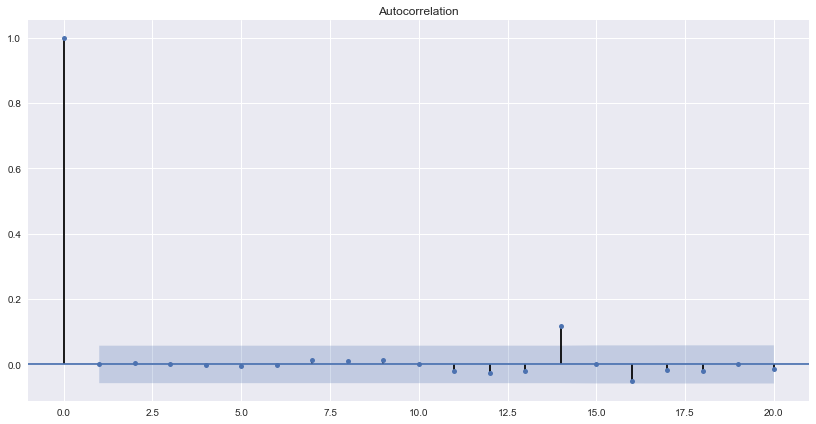

In [38]:
#Check the residuals
acf_compute(result_ma.resid, nlags = 20)

The moving average model's residuals exhibit white noise properties.  There is only 1 residual that is significant, which can be true with a 5% level of significance in 20 lags. All the other autocorrelation estimates exhibit no patterns.

Jarque-Bera test statistic: 505.719
Jarque-Bera p-value:       1.529E-110
Estimated skew:             0.125
Estimated kurtosis:         6.212
-------------------
The null hypothesis is rejected and the data does not come
from a normal distribution


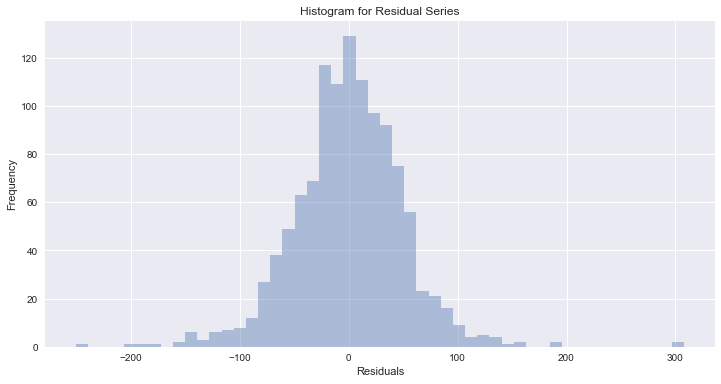

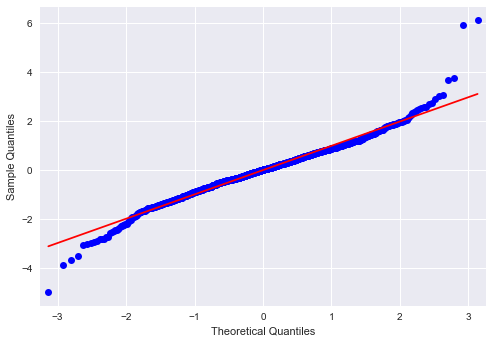

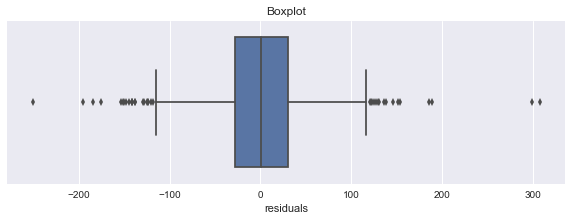

In [39]:
normal_test(result_ma.resid)

## Predictions with the MA(8) Model
Predictions for the MA(8) model is constructed.  Again, the AR(2) model is not adequate but is done to compare against the MA(8) model.
Predcitions are made on the  in-sample data.

In [59]:
# Recall the end of the train data.
train.tail()

dt
2017-09-08   -33.415228
2017-09-09    16.277923
2017-09-10    15.351896
2017-09-11   -21.487145
2017-09-12     0.615594
Freq: D, dtype: float64

array([-5.16585893,  5.17170578,  0.89834761,  4.86276299,  2.12916461,
       -0.35216568, -0.69764916])

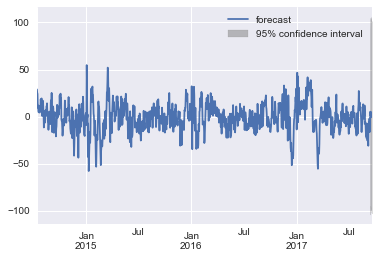

In [397]:
# Perform 1-step ahead forecast
pred_1 = result_ma.forecast(steps = 7)[0]
ma_preds = result_ma.plot_predict(start = '2014-07-13', end ='2017-09-19', plot_insample = False)
pred_1

In [417]:
# Create a data frame for easier access 
test_series = pd.DataFrame({'time':test.index, 'value':test.values})
test_7 = test_series[0:7]

## Prediciton results
The RMSE is high, but the predicted results do catch the sign changes 5 out of the 6 sign changes in the forecasted forecasted results.

In [433]:
# Print out the results
for i in range(len(test_7)):
    print("Prediction = {0:>7.3f}, Observed = {1:>8.3f}".format (pred_1[i], test_7['value'][i]))

# The MSE is pretty large
mse = mean_squared_error(test_7['value'], pred_1)
rmse = np.sqrt(mse)
print("----------------")
print("RMSE: {0:.5f}".format(rmse))

Prediction =  -5.166, Observed =  -45.287
Prediction =   5.172, Observed =  -31.236
Prediction =   0.898, Observed =   29.412
Prediction =   4.863, Observed =   51.953
Prediction =   2.129, Observed =   -4.623
Prediction =  -0.352, Observed =  -23.347
Prediction =  -0.698, Observed =  -51.204
----------------
RMSE: 36.03791
